In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import numpy as np
from numpy import *
import numpy.random as rng
import os
import matplotlib.pyplot as plt
from models.pointnet2_utils import PointNetSetAbstractionMsg, PointNetSetAbstraction
from sklearn.metrics import accuracy_score

In [2]:
torch.cuda.set_device(2)
# os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

In [3]:

class get_model(nn.Module):
    def __init__(self,num_class=10,normal_channel=False):
        super(get_model, self).__init__()
        in_channel = 3 if normal_channel else 0
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstractionMsg(512, [0.1, 0.2, 0.4], [16, 32, 128], in_channel,[[32, 32, 64], [64, 64, 128], [64, 96, 128]])
        self.sa2 = PointNetSetAbstractionMsg(128, [0.2, 0.4, 0.8], [32, 64, 128], 320,[[64, 64, 128], [128, 128, 256], [128, 128, 256]])
        self.sa3 = PointNetSetAbstraction(None, None, None, 640 + 3, [256, 512, 1024], True)
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256,5)
        self.fc5 = nn.Linear(100, 1)
    
    def forward_once(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        output = self.fc3(x)
        return output
    
    def forward(self, input1, input2):
  
        output1 = self.forward_once(input1)

        output2 = self.forward_once(input2)
        
#         dis = F.pairwise_distance(output1, output2)
#         dis = torch.abs(output1 - output2)

#         pre = torch.sigmoid(self.fc5(dis.unsqueeze(-1)))
#         pre = self.fc5(dis)
#         pre = torch.sigmoid(self.fc5(dis))
#         print("pre = ", pre)
        
        return output1,output2


In [4]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):

        euclidean_distance = F.pairwise_distance(output1, output2)

        print(euclidean_distance)

        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
#         print("test:", loss_contrastive)
        return loss_contrastive*0.5

In [5]:
def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

In [6]:
import os
def train_data(batch_size = 12):    
    split='train'
    root = "/home/jovyan/code/PointCloudClassifier/PointNet/pointnet/modelnet40_normal_resampled"
    npoints = 1024
    num_category = 10 

    catfile = os.path.join(root, 'modelnet10_shape_names.txt')

    cat = [line.rstrip() for line in open(catfile)]  # 以列表的形式存放40类物品
#     print(cat)
    classes = dict(zip(cat, range(len(cat))))
#     print(classes)
   
    shape_ids = {}
    shape_ids['train'] = [line.rstrip() for line in open(os.path.join(root, 'modelnet10_train.txt'))]
    shape_ids['test'] = [line.rstrip() for line in open(os.path.join(root, 'modelnet10_test.txt'))]

    assert (split == 'train' or split == 'test')
    shape_names = ['_'.join(x.split('_')[0:-1]) for x in shape_ids[split]]
#     print(shape_names)
    datapath = [(shape_names[i], os.path.join(root, shape_names[i], shape_ids[split][i]) + '.txt') 
                for i in range(len(shape_ids[split]))]

#     数据打乱
    np.random.shuffle(datapath)
    
#     print('The size of %s data is %d' % (split, len(datapath)))

    save_path = os.path.join(root, 'modelnet%d_%s_%dpts.dat' % (num_category, split, npoints))
#     print(datapath)


    if split == 'train':    
        y_train_point = []
        for index in range(len(datapath)):
            cls = classes[datapath[index][0]]
            y_train_point.append(cls)
        
        y_train_point = np.array(y_train_point).astype(np.int32)
        
        #将y_train_point里边的元素按照元素类别分类，indices存储的是每个元素的位置
        indices = [np.where(y_train_point == i)[0] for i in sorted(list(set(y_train_point)))]
        
        n_classes = len(sorted(list(set(y_train_point))))
    if split == 'test':
        y_test_point = []
        for index in range(len(datapath)):
            cls = classes[datapath[index][0]]
            y_test_point.append(cls)

        y_test_point = np.array(y_test_point).astype(np.int32)

        indices = [np.where(y_test_point == i)[0] for i in sorted(list(set(y_test_point)))]
        n_classes = len(sorted(list(set(y_test_point))))   

    X_indices = indices
#     print(np.loadtxt(datapath[1][1], delimiter=','))
    point_set = np.loadtxt(datapath[1][1], delimiter=',').astype(np.float32)[0:npoints, :]  #要改为3个长度的数据
#     print(point_set)
    point_set = point_set[:, 0:3]
#     print(point_set.shape)
    w, h = point_set.shape

    categories = rng.choice(n_classes,size=(batch_size,),replace=True)
#     print(categories)

    pairs=[np.zeros((batch_size, w,h)) for i in range(2)]

    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
#     targets=np.ones((batch_size,))
#     targets[batch_size//2:] = 0

    for i in range(batch_size):
        category = categories[i]
        n_examples = len(X_indices[category])
        if(n_examples==0):
            print("error:n_examples==0",n_examples)
        idx_1 = rng.randint(0, n_examples)

        pairs[0][i,:,:] = pc_normalize(np.loadtxt(datapath[X_indices[category][idx_1]][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3])
#         pairs[0][i,:,:] = np.loadtxt(datapath[X_indices[category][idx_1]][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3]
        
#         print(datapath[X_indices[category][idx_1]][1])

        if i >= batch_size // 2:
            category_2 = category  
            idx_2 = (idx_1 + rng.randint(1,n_examples)) % n_examples
        else:        
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
            n_examples = len(X_indices[category_2])
            idx_2 = rng.randint(0, n_examples)
        pairs[1][i,:,:] = pc_normalize(np.loadtxt(datapath[X_indices[category_2][idx_2]][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3])
#         pairs[1][i,:,:] = np.loadtxt(datapath[X_indices[category_2][idx_2]][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3]
        
#         print(datapath[X_indices[category_2][idx_2]][1])
    pairs = torch.from_numpy(np.array(pairs).astype(np.float32))
#     pairs = pairs.transpose(3, 2)

    
    pairs = pairs.transpose(3, 2).cuda()
    return pairs,targets,categories

In [7]:
# train_data(batch_size = 12)

In [8]:
def test_data(idx = 2120):
    npoints = 1024    
    split='test'
    root = "/home/jovyan/code/PointCloudClassifier/PointNet/pointnet/modelnet40_normal_resampled"
    num_category = 10 

    catfile = os.path.join(root, 'modelnet10_shape_names.txt')

    cat = [line.rstrip() for line in open(catfile)]  # 以列表的形式存放40类物品
    classes = dict(zip(cat, range(len(cat))))
    shape_ids = {}

    shape_ids['train'] = [line.rstrip() for line in open(os.path.join(root, 'modelnet10_train.txt'))]
    shape_ids['test'] = [line.rstrip() for line in open(os.path.join(root, 'modelnet10_test.txt'))]

    assert (split == 'train' or split == 'test')
    shape_names = ['_'.join(x.split('_')[0:-1]) for x in shape_ids[split]]
    datapath = [(shape_names[i], os.path.join(root, shape_names[i], shape_ids[split][i]) + '.txt') 
                for i in range(len(shape_ids[split]))]
    
#     print('The size of %s data is %d' % (split, len(datapath)))

    np.random.shuffle(datapath)
    save_path = os.path.join(root, 'modelnet%d_%s_%dpts.dat' % (num_category, split, npoints))

    if split == 'train':    
        y_train_point = []
        for index in range(len(datapath)):
            cls = classes[datapath[index][0]]
            y_train_point.append(cls)

        y_train_point = np.array(y_train_point).astype(np.int32)

        indices = [np.where(y_train_point == i)[0] for i in sorted(list(set(y_train_point)))]
        n_classes = len(sorted(list(set(y_train_point))))
    if split == 'test':
        y_test_point = []
        for index in range(len(datapath)):
            cls = classes[datapath[index][0]]
            y_test_point.append(cls)
        
        #需要输出，表示分类标签，908
        y_test_point = np.array(y_test_point).astype(np.int32)

        indices = [np.where(y_test_point == i)[0] for i in sorted(list(set(y_test_point)))]
        sort_classes = sorted(list(set(y_test_point)))
        n_classes = len(sorted(list(set(y_test_point))))
        N = n_classes
  
        #这里
#         point_set = np.loadtxt(datapath[1][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3]
        point_set = pc_normalize(np.loadtxt(datapath[1][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3])#要改为3个长度的数据
        w, h = point_set.shape

        temp = np.loadtxt(datapath[idx][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3]
        test_image = np.asarray([temp]*N).reshape(N, w, h)
        
        support_set = np.zeros((N,w,h))

        for index in range(N):
            #这里
            support_set[index,:,:] = pc_normalize(np.loadtxt(datapath[int(rng.choice(indices[index],size=(1,),replace=False))][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3])
#             support_set[index,:,:] = np.loadtxt(datapath[int(rng.choice(indices[index],size=(1,),replace=False))][1], delimiter=',').astype(np.float32)[0:npoints, :][:, 0:3]
            

        targets = np.zeros((N,))
        
        true_index = sort_classes.index(y_test_point[idx])
        targets[true_index] = 1

        categories = sort_classes
        pairs = [test_image,support_set]
        pairs = torch.from_numpy(np.array(pairs).astype(np.float32))
        pairs = pairs.transpose(3, 2).cuda()
        
    return pairs,targets,categories,y_test_point

In [9]:
def test_oneshot(model,verbose=0):

    n_correct = 0
    k = 5
    preds = []
    probs_all = []
    err_print_num = 0
    for idx in range(k):
        inputs,targets,categories,_ = test_data(idx) #通过函数调用测试数据
        model.eval()
        output1,output2 = model(inputs[0],inputs[1])  #需要改
#         probs.detach() #将图中的变量解除出来
        #probs = F.pairwise_distance(output1, output2)
           
        euclidean_distance = F.pairwise_distance(output1, output2)

#         diff = euclidean_distance.cpu().detach().numpy()[0]
#         print(euclidean_distance.cpu().detach().numpy()[0])


        if np.argmin(euclidean_distance.detach().cpu().numpy()) == np.argmax(targets):
#         if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
            
        preds.append([categories[np.argmax(targets)],categories[np.argmin(euclidean_distance.detach().cpu().numpy())]])
        probs_all.append(euclidean_distance)

    percent_correct = (100.0*n_correct / k)
    print("*"*50)
    print(n_correct)
#     print(probs)

    return percent_correct,np.array(preds),np.array(probs_all)

In [10]:
model = get_model()
#criterion = ContrastiveLoss()
# model = nn.DataParallel(model)
model.cuda()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.001)

# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCELoss()
criterion = ContrastiveLoss()

#loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = F.binary_cross_entropy(pred.squeeze(), targets_tensor.float().cuda())

In [11]:
# targets_tensor = torch.from_numpy(targets)
# loss_fn = F.binary_cross_entropy(pred.squeeze(), targets_tensor.float().cuda())
# optimizer.zero_grad()dd
# loss.backward()
# optimizer.step()

In [12]:
loss_history = []
def train(inputs,targets, model, loss_fn, optimizer):
    
    y = torch.from_numpy(targets).float().cuda()          
    model.train()
    
    output1, output2 = model(inputs[0],inputs[1]) 


#     loss = loss_fn(pred.squeeze(), y)

    optimizer.zero_grad()

    loss = loss_fn(output1, output2, y)    
    
    print("loss: ", loss)
    loss.backward()
    loss_history.append(loss.data.item())
    optimizer.step()
#     print(pred)
#     print(loss)

In [13]:
def test(dataloader, model, loss_fn):
   
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 100
correct_list = []
i = 0
# pairs,targets,categories = train_data(32)
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    pairs,targets,categories = train_data(10)
    train(pairs,targets, model, criterion, optimizer)
    if t % 50 == 0:
        i += 1
        print(f"Epoch {t+1}\n-------------------------------")
        with torch.no_grad():
            percent_correct,_,_ = test_oneshot(model)
        correct_list.append(percent_correct)
        print("*"*50)
        
        print(percent_correct)
        print("*"*50)
#     test(test_dataloader, model, loss_fn)
print("Done!")



tensor([2.3306, 2.2283, 1.8579, 1.9793, 1.2166, 2.7495, 2.1415, 0.9792, 0.7008,
        2.9113], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(1.1353, device='cuda:2', grad_fn=<MulBackward0>)
Epoch 1
-------------------------------
**************************************************
2
**************************************************
40.0
**************************************************
tensor([1.1835, 1.4561, 2.0634, 1.6612, 0.8319, 1.3581, 1.9828, 1.2736, 1.5541,
        1.1984], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.6846, device='cuda:2', grad_fn=<MulBackward0>)
tensor([0.9384, 1.7378, 0.7399, 0.9398, 2.1755, 1.2724, 0.7807, 2.3526, 1.6952,
        1.2981], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.8115, device='cuda:2', grad_fn=<MulBackward0>)
tensor([1.8145, 1.8559, 1.5806, 1.1013, 0.9038, 1.7910, 1.3966, 2.1300, 1.9515,
        1.1483], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.8531, device='cuda:2', grad_fn=<MulBack

tensor([2.7126, 2.1512, 1.1979, 1.6559, 1.2977, 1.7698, 0.7987, 2.0956, 2.0536,
        1.7813], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.8403, device='cuda:2', grad_fn=<MulBackward0>)
tensor([3.2247, 0.7125, 1.9731, 1.4164, 1.4527, 1.6505, 2.4017, 2.9501, 1.0229,
        2.1726], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(1.2630, device='cuda:2', grad_fn=<MulBackward0>)
tensor([1.1207, 1.3450, 0.9926, 0.9604, 2.2965, 0.9873, 1.4294, 1.6814, 0.6989,
        1.5592], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.6031, device='cuda:2', grad_fn=<MulBackward0>)
tensor([1.1258, 1.9647, 1.1618, 1.5239, 1.4144, 0.6771, 1.6119, 1.6434, 0.5874,
        1.1191], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.4696, device='cuda:2', grad_fn=<MulBackward0>)
tensor([0.8145, 1.3429, 0.9708, 1.6863, 1.5780, 1.1262, 1.5384, 1.7103, 1.3156,
        3.1496], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(1.0692, device='cuda:2', grad_fn=<MulBa

tensor([1.1623, 2.0020, 1.0829, 1.4954, 0.8474, 0.9376, 2.3307, 1.9387, 0.8291,
        1.6895], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.8369, device='cuda:2', grad_fn=<MulBackward0>)
tensor([1.3913, 1.3042, 1.1091, 0.6170, 1.5088, 1.2986, 1.0114, 0.7103, 1.3443,
        1.3967], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.5387, device='cuda:2', grad_fn=<MulBackward0>)
tensor([2.2256, 2.2590, 1.7599, 2.5902, 1.2466, 1.6611, 1.0503, 0.8509, 1.6430,
        1.0062], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.4462, device='cuda:2', grad_fn=<MulBackward0>)
tensor([0.4235, 1.8065, 1.6553, 1.4412, 0.3679, 1.5057, 2.2635, 2.0292, 0.5675,
        1.1589], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.9396, device='cuda:2', grad_fn=<MulBackward0>)
tensor([1.8265, 1.0042, 1.3932, 2.0329, 2.0901, 0.7712, 0.4594, 0.8761, 1.0344,
        1.0721], device='cuda:2', grad_fn=<NormBackward1>)
loss:  tensor(0.2591, device='cuda:2', grad_fn=<MulBa

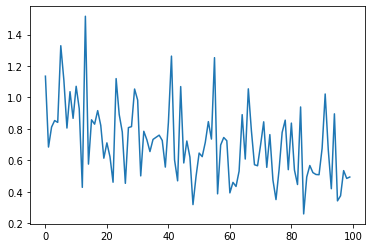

In [15]:
x = range(0,epochs)
plt.plot(x, loss_history)
plt.savefig("./mypicture/train_10000")
plt.show()

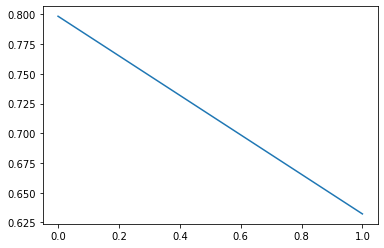

In [16]:
value = 50
loss_ave = []
j = 0
x = range(0,int(epochs/value))
for _ in range(0, int(epochs/value)):   
    loss_ave.append(mean(loss_history[j:j+value]))
    j += value
plt.plot(x, loss_ave)
plt.savefig("./mypicture/train_200")
plt.show()

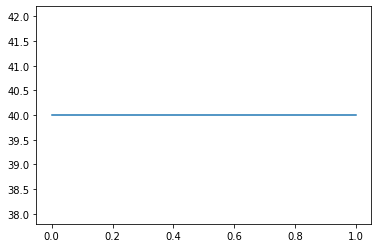

In [17]:
x = range(0,i)
plt.plot(x, correct_list)
plt.savefig("./mypicture/test_10000")
plt.show()